# Copenhagen Hourly Bike Traffic Modeling - Demo

This notebook demonstrates the full pipeline for modeling hourly bike ridership in Copenhagen.

## Pipeline Overview

1. **Data Preparation**: Load CSVs, auto-detect schemas, clean, split train/test
2. **Feature Engineering**: H3 spatial indexing, KNN neighbor graphs, temporal features
3. **Spatial CV**: Create H3-based spatial folds
4. **Model Training**: XGBoost OOF → CatBoost with neighbor lags
5. **Explainability**: SHAP analysis
6. **Visualization**: Interactive AADBT map


In [1]:
# Setup
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent))

from src.utils import setup_logging, set_seeds
from src.prepare_data import prepare_data_pipeline
from src.features import feature_engineering_pipeline, apply_features_to_test
from src.advanced_features import advanced_features_pipeline
from src.spatial_cv import spatial_cv_pipeline
from src.models import models_pipeline, rolling_window_validation
from src.explain import explain_pipeline
from src.map_viz import map_viz_pipeline

# Paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"

# Setup logging and seeds
logger = setup_logging()
set_seeds(42)

print(f"Data directory: {DATA_DIR}")
print(f"Artifacts directory: {ARTIFACTS_DIR}")


/Users/elopna/code/my_projects/music_n_voice_separator/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data directory: /Users/elopna/code/my_projects/ridership_modelling/cph-aadbt-mini/data
Artifacts directory: /Users/elopna/code/my_projects/ridership_modelling/cph-aadbt-mini/artifacts


## Stage 1: Data Preparation

Load CSVs, automatically detect schema, clean data, and split into train/test.


In [2]:
prepare_data_pipeline(
    data_dir=DATA_DIR,
    artifacts_dir=ARTIFACTS_DIR,
    freq="hour",
    test_size=0.2,
)

print("\n✓ Data preparation complete")


2025-11-22 02:11:44 [INFO] Loading CSV files...
2025-11-22 02:11:44 [INFO] Loaded rides.csv: 2,210,160 rows, 5 columns
2025-11-22 02:11:45 [INFO] Loaded total_rides.csv: 684,120 rows, 4 columns
2025-11-22 02:11:45 [INFO] Loaded road_info.csv: 13 rows, 4 columns
2025-11-22 02:11:45 [INFO] 
/Users/elopna/code/my_projects/ridership_modelling/cph-aadbt-mini/src/schema_detect.py:71: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  parsed = pd.to_datetime(df[col], errors="coerce")
2025-11-22 02:11:45 [INFO] Schema detected for rides.csv:
2025-11-22 02:11:45 [INFO]   time       -> date
2025-11-22 02:11:45 [INFO]   site_id    -> road_name
2025-11-22 02:11:45 [INFO]   count      -> n
2025-11-22 02:11:45 [INFO]   lat        -> NOT FOUND
2025-11-22 02:11:45 [INFO]   lon        -> NOT FOUND
2025-11-22 02:11:45 [INFO] 
/Users/elopna/code/my_projects/ridership_mode


✓ Data preparation complete


In [3]:
# Inspect prepared data
import pandas as pd

train_df = pd.read_parquet(ARTIFACTS_DIR / "train.parquet")
test_df = pd.read_parquet(ARTIFACTS_DIR / "test.parquet")

print(f"Train: {train_df.shape[0]:,} rows x {train_df.shape[1]} columns")
print(f"Test:  {test_df.shape[0]:,} rows x {test_df.shape[1]} columns")
print(f"\nDate range: {train_df['timestamp'].min()} to {test_df['timestamp'].max()}")
print(f"Unique sites: {train_df['site_id'].nunique()}")

train_df.head()


Train: 535,814 rows x 11 columns
Test:  147,619 rows x 11 columns

Date range: 2005-01-01 00:00:00 to 2014-12-31 23:00:00
Unique sites: 13


,site_id,timestamp,count,date,hour,dow,month,is_weekend,lat,lon,split
0,Englandsvej,2005-01-01 00:00:00,5.0,2005-01-01,0,5,1,1,55.638347,12.599838,train
1,Tuborgvej,2005-01-01 00:00:00,5.0,2005-01-01,0,5,1,1,55.718348,12.539868,train
2,Tuborgvej,2005-01-01 01:00:00,32.0,2005-01-01,1,5,1,1,55.718348,12.539868,train
3,Englandsvej,2005-01-01 01:00:00,13.0,2005-01-01,1,5,1,1,55.638347,12.599838,train
4,Englandsvej,2005-01-01 02:00:00,10.0,2005-01-01,2,5,1,1,55.638347,12.599838,train


## Stage 2: Feature Engineering

Add spatial features (H3, KNN neighbors, distance to center) and temporal features.


In [4]:
feature_engineering_pipeline(
    artifacts_dir=ARTIFACTS_DIR,
    neighbors=4,
)

print("\n✓ Feature engineering (train) complete")


2025-11-22 02:11:48 [INFO] Loading train data...
2025-11-22 02:11:48 [INFO] Train data: 535,814 rows, 11 columns
2025-11-22 02:11:48 [INFO] 
Adding H3 spatial features...
2025-11-22 02:11:50 [INFO] Added H3 resolution 8: 12 unique cells
2025-11-22 02:11:52 [INFO] Added H3 resolution 7: 10 unique cells
2025-11-22 02:11:52 [INFO] 
Adding distance to geocenter...
2025-11-22 02:11:52 [INFO] Computing geocenter: lat=55.685199, lon=12.539430
2025-11-22 02:11:52 [INFO] Saved: /Users/elopna/code/my_projects/ridership_modelling/cph-aadbt-mini/artifacts/geocenter.pkl
2025-11-22 02:11:52 [INFO] 
Building KNN neighbor graph (k=4)...
2025-11-22 02:11:52 [INFO] Building KNN graph for 13 sites with k=4
2025-11-22 02:11:52 [INFO] Neighbor graph built. Mean distance to nearest neighbor: 1.63 km
2025-11-22 02:11:52 [INFO] Saved: /Users/elopna/code/my_projects/ridership_modelling/cph-aadbt-mini/artifacts/neighbor_graph.pkl
2025-11-22 02:11:52 [INFO] 
Adding neighbor density features...
2025-11-22 02:11:5


✓ Feature engineering (train) complete


In [5]:
# Apply features to test
apply_features_to_test(ARTIFACTS_DIR)

print("\n✓ Feature engineering (test) complete")


2025-11-22 02:11:57 [INFO] Loading test data and neighbor graph...
2025-11-22 02:11:57 [INFO] Test data: 147,619 rows, 11 columns
2025-11-22 02:11:57 [INFO] 
Applying features to test set...
2025-11-22 02:11:58 [INFO] Added H3 resolution 8: 12 unique cells
2025-11-22 02:11:58 [INFO] Added H3 resolution 7: 10 unique cells
2025-11-22 02:11:58 [INFO] Using provided geocenter: lat=55.685199, lon=12.539430
2025-11-22 02:11:58 [INFO] Neighbor density features removed (0 SHAP importance)
2025-11-22 02:12:00 [INFO] Added neighbor aggregate distance features
2025-11-22 02:12:00 [INFO] Added cyclical features: hour (sin/cos), year_day (sin/cos)
2025-11-22 02:12:00 [INFO] 
Adding one-hot encoding for h3_r8 (aligned with train)...
2025-11-22 02:12:00 [INFO] Created 12 one-hot features for h3_r8
2025-11-22 02:12:00 [INFO] Aligned H3 one-hot columns: 12 features
2025-11-22 02:12:00 [INFO] Saved: /Users/elopna/code/my_projects/ridership_modelling/cph-aadbt-mini/artifacts/features_test.parquet
2025-11


✓ Feature engineering (test) complete


## Stage 2.5: Advanced Features

Add weather, holidays, and lagged features to improve predictions.


In [6]:
# Weather file path
WEATHER_PATH = DATA_DIR / "open-meteo-55.71N12.44E6m.csv"

advanced_features_pipeline(
    artifacts_dir=ARTIFACTS_DIR,
    weather_path=WEATHER_PATH,
    location_id=0,  # First location in weather file
    add_lags=False,  # Lags will be added during model training to avoid leakage
)

print("\n✓ Advanced features complete")


2025-11-22 02:12:00 [INFO] ============================================================
2025-11-22 02:12:00 [INFO] Advanced Features Pipeline
2025-11-22 02:12:00 [INFO] ============================================================
2025-11-22 02:12:00 [INFO] Loaded train: 535,814 rows, 32 cols
2025-11-22 02:12:00 [INFO] Loaded test:  147,619 rows, 32 cols
2025-11-22 02:12:00 [INFO] 
Adding weather features...
2025-11-22 02:12:00 [INFO] Loading weather data from /Users/elopna/code/my_projects/ridership_modelling/cph-aadbt-mini/data/open-meteo-55.71N12.44E6m.csv
2025-11-22 02:12:00 [INFO] Loaded 87,648 weather records
2025-11-22 02:12:00 [INFO] Added weather features: temperature, wind_speed, rain, snowfall
2025-11-22 02:12:00 [INFO] Loading weather data from /Users/elopna/code/my_projects/ridership_modelling/cph-aadbt-mini/data/open-meteo-55.71N12.44E6m.csv
2025-11-22 02:12:01 [INFO] Loaded 87,648 weather records
2025-11-22 02:12:01 [INFO] Added weather features: temperature, wind_speed, 


✓ Advanced features complete


In [7]:
spatial_cv_pipeline(
    artifacts_dir=ARTIFACTS_DIR,
    cv_folds=5,
)

print("\n✓ Spatial CV folds created")

2025-11-22 02:12:02 [INFO] Loading features data...
2025-11-22 02:12:02 [INFO] Data shape: 535,814 rows, 36 columns
2025-11-22 02:12:02 [INFO] Creating 5 spatial folds using h3_r7...
2025-11-22 02:12:02 [INFO] Number of unique H3 blocks: 10
2025-11-22 02:12:02 [INFO] Fold 1/5: train 9 blocks (428,111 rows), valid 1 blocks (107,703 rows)
2025-11-22 02:12:02 [INFO] Fold 2/5: train 8 blocks (409,773 rows), valid 2 blocks (126,041 rows)
2025-11-22 02:12:02 [INFO] Fold 3/5: train 8 blocks (430,999 rows), valid 2 blocks (104,815 rows)
2025-11-22 02:12:02 [INFO] Fold 4/5: train 7 blocks (432,378 rows), valid 3 blocks (103,436 rows)
2025-11-22 02:12:02 [INFO] Fold 5/5: train 8 blocks (441,995 rows), valid 2 blocks (93,819 rows)
2025-11-22 02:12:02 [INFO] Saved folds to /Users/elopna/code/my_projects/ridership_modelling/cph-aadbt-mini/artifacts/folds.pkl
2025-11-22 02:12:02 [INFO] 
Spatial CV folds created successfully!



✓ Spatial CV folds created


In [8]:
models_pipeline(
    artifacts_dir=ARTIFACTS_DIR,
)

print("\n✓ Model training complete")

2025-11-22 02:12:02 [INFO] Loading data...
2025-11-22 02:12:02 [INFO] Loaded 5 folds from /Users/elopna/code/my_projects/ridership_modelling/cph-aadbt-mini/artifacts/folds.pkl
2025-11-22 02:12:02 [INFO] Train: 535,814 rows, 36 columns
2025-11-22 02:12:02 [INFO] Test:  147,619 rows, 36 columns
2025-11-22 02:12:02 [INFO] Folds: 5
2025-11-22 02:12:02 [INFO] XGBoost base features: 30 (including 12 H3 one-hot)
2025-11-22 02:12:02 [INFO] Lagged features will be computed inside each fold to prevent data leakage
2025-11-22 02:12:02 [INFO] ============================================================
2025-11-22 02:12:02 [INFO] Stage 1: XGBoost OOF Baseline
2025-11-22 02:12:02 [INFO] ============================================================
2025-11-22 02:12:02 [INFO] XGBoost parameters: {'max_depth': 6, 'n_estimators': 800, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_lambda': 1.0, 'objective': 'reg:squarederror', 'random_state': 42, 'n_jobs': -1, 'tree_method': 'hist

0:	learn: 352.1957413	total: 81.8ms	remaining: 2m 2s
100:	learn: 103.2477472	total: 6.71s	remaining: 1m 33s
200:	learn: 91.4276268	total: 13.8s	remaining: 1m 29s
300:	learn: 86.3511103	total: 21.2s	remaining: 1m 24s
400:	learn: 82.7189087	total: 27.8s	remaining: 1m 16s
500:	learn: 79.9844924	total: 34.4s	remaining: 1m 8s
600:	learn: 77.8662140	total: 41.2s	remaining: 1m 1s
700:	learn: 75.9943886	total: 48.2s	remaining: 55s
800:	learn: 74.4398735	total: 55.1s	remaining: 48.1s
900:	learn: 73.0608566	total: 1m 1s	remaining: 41.1s
1000:	learn: 71.7983123	total: 1m 8s	remaining: 34.3s
1100:	learn: 70.5999834	total: 1m 15s	remaining: 27.4s
1200:	learn: 69.6354804	total: 1m 22s	remaining: 20.5s
1300:	learn: 68.7881910	total: 1m 29s	remaining: 13.8s
1400:	learn: 67.9423928	total: 1m 37s	remaining: 6.86s


2025-11-22 02:17:30 [INFO] Predicting on TEST set...


1499:	learn: 67.1987441	total: 1m 43s	remaining: 0us


2025-11-22 02:17:30 [INFO] 
2025-11-22 02:17:30 [INFO] TEST SET Performance:
2025-11-22 02:17:30 [INFO]   RMSE: 117.6017
2025-11-22 02:17:30 [INFO]   MAE: 60.1104
2025-11-22 02:17:30 [INFO]   MAPE: 39.5848
2025-11-22 02:17:30 [INFO]   WAPE: 23.1551
2025-11-22 02:17:30 [INFO] ============================================================

2025-11-22 02:17:30 [INFO] Saved: /Users/elopna/code/my_projects/ridership_modelling/cph-aadbt-mini/artifacts/test_predictions.parquet
2025-11-22 02:17:30 [INFO] Test predictions shape: 147,619 rows, 37 columns
2025-11-22 02:17:30 [INFO] Unique sites in test predictions: 13
2025-11-22 02:17:30 [INFO] Saved: /Users/elopna/code/my_projects/ridership_modelling/cph-aadbt-mini/artifacts/model_results.pkl
2025-11-22 02:17:30 [INFO] 
Saving metrics summary...
2025-11-22 02:17:30 [INFO] Saved: /Users/elopna/code/my_projects/ridership_modelling/cph-aadbt-mini/artifacts/cv_metrics.csv
2025-11-22 02:17:30 [INFO] 
=== MEAN CV METRICS (10 folds) ===
2025-11-22 02:17:


✓ Model training complete


## Stage 3.5: Rolling Window Validation

Evaluate model performance with sliding time windows:
- Train on 2 consecutive years
- Test on the following 1 year  
- Slide through all available years
- Average metrics across all windows


In [9]:
rolling_results = rolling_window_validation(
    artifacts_dir=ARTIFACTS_DIR,
    train_years=2,
    test_years=1,
)

print("\n✓ Rolling window validation complete")
print(f"\nAverage XGBoost WAPE: {rolling_results['avg_xgb_wape']:.2f}%")
print(f"Average CatBoost WAPE: {rolling_results['avg_cb_wape']:.2f}%")


2025-11-22 02:17:30 [INFO] ============================================================
2025-11-22 02:17:30 [INFO] Rolling Window Validation
2025-11-22 02:17:30 [INFO] ============================================================
2025-11-22 02:17:30 [INFO] Train window: 2 years
2025-11-22 02:17:30 [INFO] Test window: 1 years
2025-11-22 02:17:30 [INFO] 
2025-11-22 02:17:30 [INFO] Loaded full dataset: 683,433 rows
2025-11-22 02:17:30 [INFO] Available years: 2005-2014 (10 years)
2025-11-22 02:17:30 [INFO] Number of windows: 8
2025-11-22 02:17:30 [INFO] 
2025-11-22 02:17:30 [INFO] ============================================================
2025-11-22 02:17:30 [INFO] Window 1/8
2025-11-22 02:17:30 [INFO]   Train: 2005-2006
2025-11-22 02:17:30 [INFO]   Test:  2007-2007
2025-11-22 02:17:30 [INFO] ============================================================
2025-11-22 02:17:30 [INFO] Train: 66,198 rows, 12 sites
2025-11-22 02:17:30 [INFO] Test:  94,906 rows, 12 sites
2025-11-22 02:17:30 [INFO]


✓ Rolling window validation complete

Average XGBoost WAPE: 19.22%
Average CatBoost WAPE: 23.09%


In [10]:
explain_pipeline(
    artifacts_dir=ARTIFACTS_DIR,
    max_samples=50000,
)

print("\n✓ SHAP analysis complete")

2025-11-22 02:25:44 [INFO] Loading model and data...
2025-11-22 02:25:44 [INFO] Using CatBoost OOF predictions as spatial_oof_neighbors_mean for SHAP...
2025-11-22 02:25:44 [INFO] Creating simplified neighbor lags for SHAP...
2025-11-22 02:25:44 [INFO] Adding lagged features for SHAP...
2025-11-22 02:25:44 [INFO] Added lagged features: count_lag_24h, count_rolling_mean_7d
2025-11-22 02:25:44 [INFO] Sampling 50000 rows for SHAP (from 535,814 total)...
/Users/elopna/code/my_projects/ridership_modelling/cph-aadbt-mini/src/explain.py:154: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = train_df.groupby(["h3_r7", "hour"], group_keys=False).apply(
2025-11-22 02:25:45 [INFO] Using 50,000 samples fo


✓ SHAP analysis complete


## Results Analysis

### 1. SHAP Feature Importance


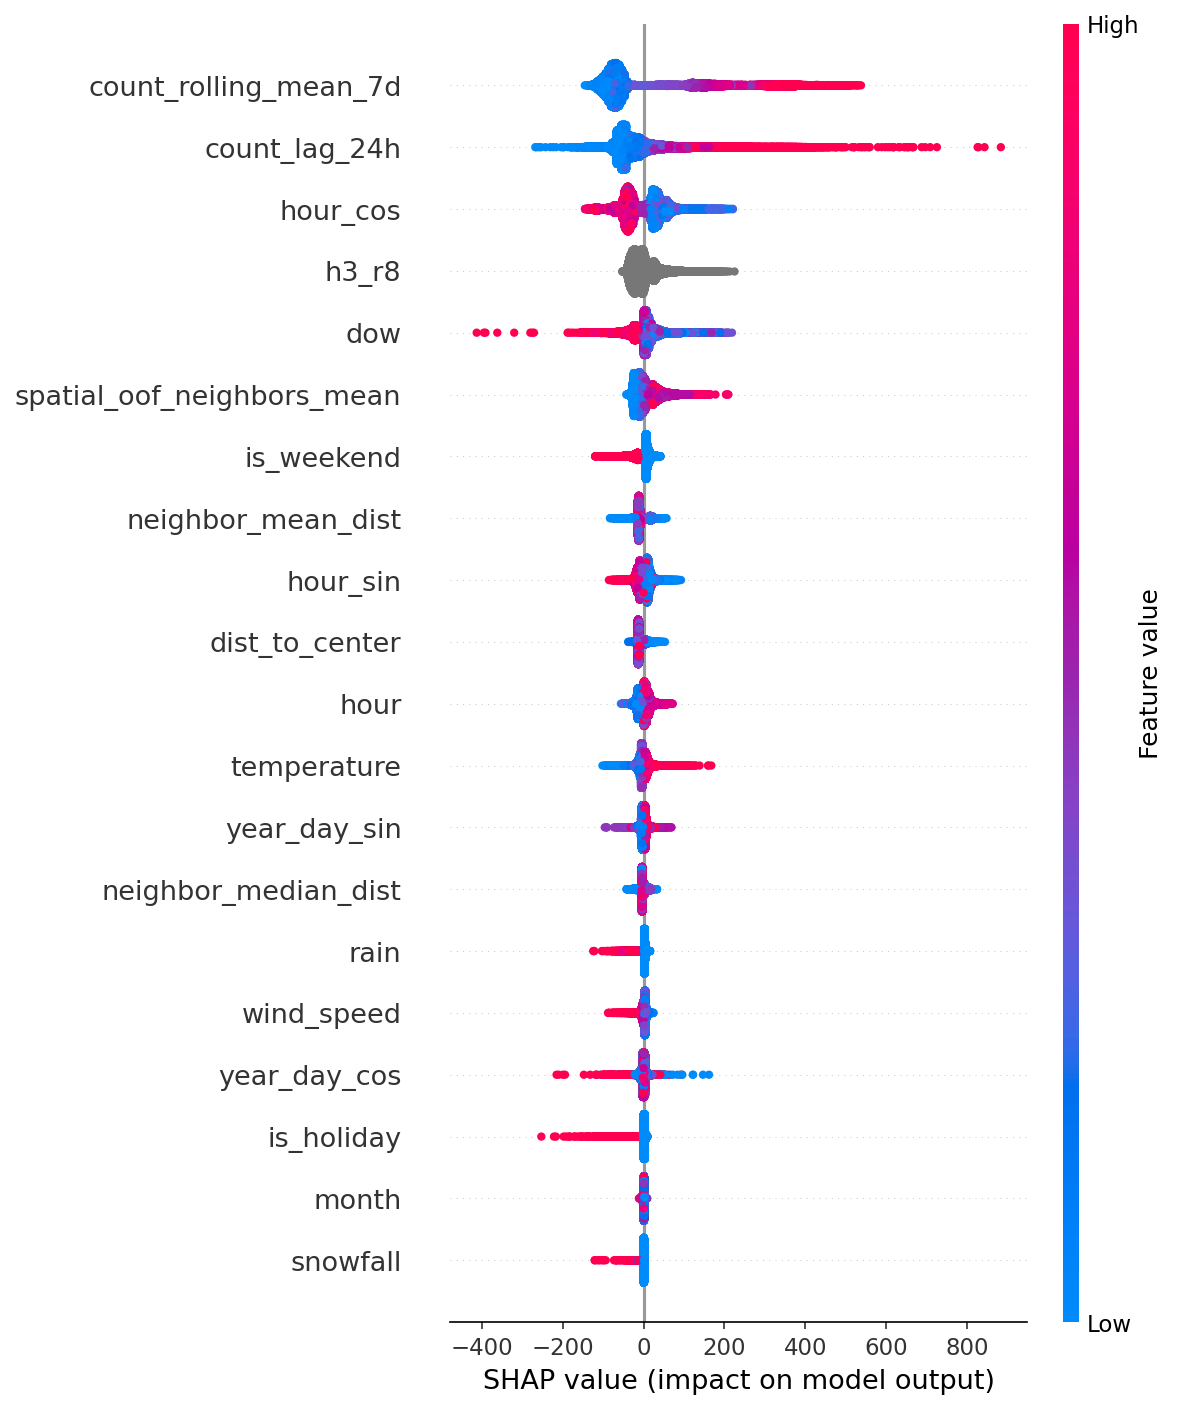


Top 15 Features by SHAP Importance:


,feature,importance
0,count_rolling_mean_7d,110.251593
1,count_lag_24h,57.931572
2,hour_cos,42.525439
3,h3_r8,23.199639
4,dow,23.195143
5,spatial_oof_neighbors_mean,21.338761
6,is_weekend,14.631631
7,neighbor_mean_dist,12.938943
8,hour_sin,11.386792
9,dist_to_center,10.892544


In [11]:
from IPython.display import Image, display
import pandas as pd

# Display SHAP summary plot
display(Image(filename=str(ARTIFACTS_DIR / "shap_summary.png")))

# Top features table
shap_df = pd.read_csv(ARTIFACTS_DIR / "shap_top_features.csv")
print("\nTop 15 Features by SHAP Importance:")
shap_df.head(15)


### 2. Test Set Predictions


In [12]:
test_preds = pd.read_parquet(ARTIFACTS_DIR / "test_predictions.parquet")

print(f"Test predictions: {len(test_preds):,} rows")
print(f"\nSample predictions:")
test_preds[['site_id', 'timestamp', 'hour', 'count', 'predicted_count']].head(20)

Test predictions: 147,619 rows

Sample predictions:


,site_id,timestamp,hour,count,predicted_count
0,Roskildevej,2013-01-07 15:00:00,15,149.0,498.237465
1,Vigerslev Allé,2013-01-07 15:00:00,15,323.0,255.432164
2,Dr. Louises Bro ( ml. Nørrebrogade og Frederik...,2013-01-07 15:00:00,15,1157.0,1180.317883
3,Ellebjergvej,2013-01-07 15:00:00,15,256.0,178.369512
4,Kalvebod Brygge,2013-01-07 15:00:00,15,230.0,246.905553
5,Åboulevard,2013-01-07 15:00:00,15,1028.0,862.852328
6,Englandsvej,2013-01-07 15:00:00,15,202.0,173.478042
7,Torvegade,2013-01-07 15:00:00,15,2102.0,1818.966638
8,Jagtvej,2013-01-07 15:00:00,15,0.0,218.877184
9,Tuborgvej,2013-01-07 15:00:00,15,348.0,303.082183


### 3. Prediction Quality Visualization


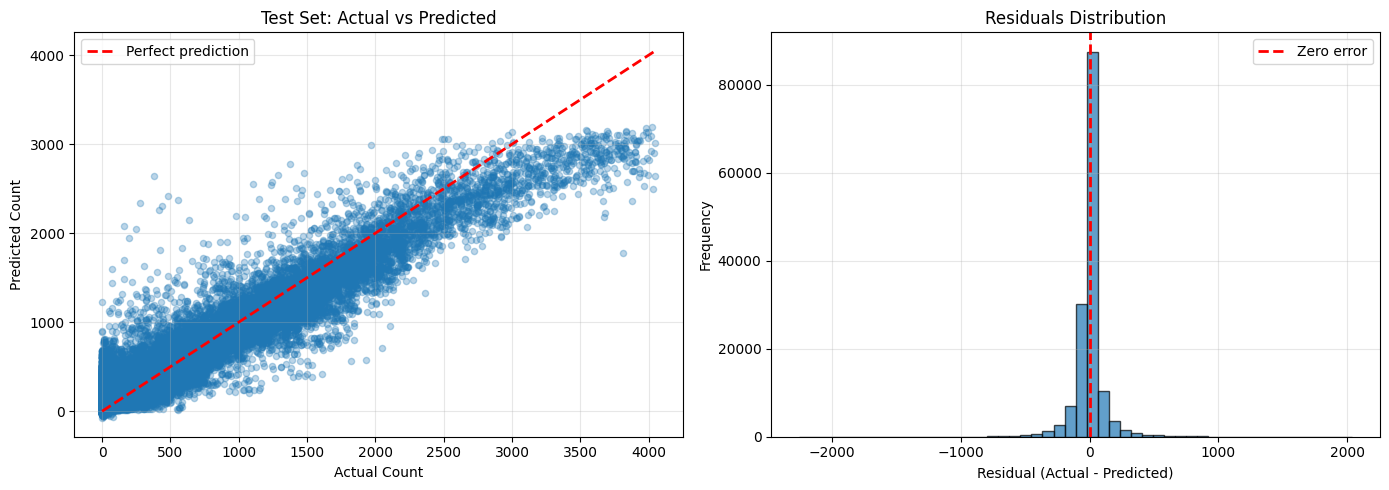

Mean residual: -3.89
Std residual: 117.54
Median absolute error: 24.60


In [13]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter: Actual vs Predicted
axes[0].scatter(test_preds['count'], test_preds['predicted_count'], alpha=0.3, s=20)
max_val = max(test_preds['count'].max(), test_preds['predicted_count'].max())
axes[0].plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Count')
axes[0].set_ylabel('Predicted Count')
axes[0].set_title('Test Set: Actual vs Predicted')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals distribution
residuals = test_preds['count'] - test_preds['predicted_count']
axes[1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residuals Distribution')
axes[1].axvline(0, color='r', linestyle='--', lw=2, label='Zero error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean residual: {residuals.mean():.2f}")
print(f"Std residual: {residuals.std():.2f}")
print(f"Median absolute error: {np.median(np.abs(residuals)):.2f}")


### 4. Temporal Patterns: Actual vs Predicted by Hour


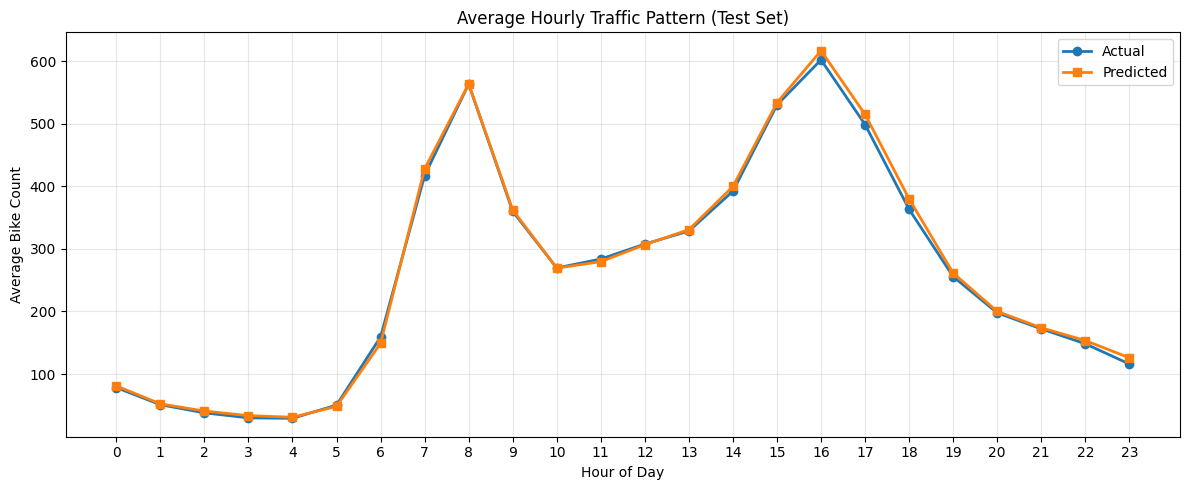

Peak hours (actual):
hour
16    601.932358
8     563.175336
15    529.827138
Name: count, dtype: float64


In [14]:
# Average traffic by hour
hourly = test_preds.groupby('hour')[['count', 'predicted_count']].mean()

plt.figure(figsize=(12, 5))
plt.plot(hourly.index, hourly['count'], marker='o', label='Actual', linewidth=2)
plt.plot(hourly.index, hourly['predicted_count'], marker='s', label='Predicted', linewidth=2)
plt.xlabel('Hour of Day')
plt.ylabel('Average Bike Count')
plt.title('Average Hourly Traffic Pattern (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

print("Peak hours (actual):")
print(hourly['count'].nlargest(3))


### 5. AADBT Analysis by Site


In [15]:
map_viz_pipeline(ARTIFACTS_DIR)

print("\n✓ Map visualization complete")
print(f"\nOpen in browser: {ARTIFACTS_DIR / 'cph_aadbt_map.html'}")

2025-11-22 02:26:01 [INFO] Loading data...
2025-11-22 02:26:02 [INFO] Train: 535,814 rows, 13 unique sites
2025-11-22 02:26:02 [INFO] Test:  147,619 rows, 13 unique sites
2025-11-22 02:26:02 [INFO] 
Computing observed AADBT for test period...
2025-11-22 02:26:02 [INFO] Computing predicted AADBT for test period...
2025-11-22 02:26:02 [INFO] Computing observed AADBT for full period...
2025-11-22 02:26:02 [INFO] Computing predicted AADBT for full period (approximated)...
2025-11-22 02:26:02 [INFO] Merging AADBT metrics by site...
2025-11-22 02:26:02 [INFO] Total sites: 13
2025-11-22 02:26:02 [INFO] 
AADBT Statistics (test period):
2025-11-22 02:26:02 [INFO]   Observed: mean=5163.8, std=6020.3
2025-11-22 02:26:02 [INFO]   Predicted: mean=5418.9, std=5538.5
2025-11-22 02:26:02 [INFO]   Error: mean=21.2%, std=55.3%
2025-11-22 02:26:02 [INFO] Creating interactive AADBT map...
2025-11-22 02:26:02 [INFO] Saved: /Users/elopna/code/my_projects/ridership_modelling/cph-aadbt-mini/artifacts/cph_aadb


✓ Map visualization complete

Open in browser: /Users/elopna/code/my_projects/ridership_modelling/cph-aadbt-mini/artifacts/cph_aadbt_map.html


In [16]:
aadbt_df = pd.read_csv(ARTIFACTS_DIR / "aadbt_by_site.csv")

print(f"Total sites: {len(aadbt_df)}")
print(f"\nAADBT Statistics (test period):")
print(aadbt_df[['aadbt_test_obs', 'aadbt_test_pred', 'error_pct']].describe())

print("\n\nBest predictions (lowest error):")
print(aadbt_df.nsmallest(5, 'error_pct')[['site_id', 'aadbt_test_obs', 'aadbt_test_pred', 'error_pct']])

print("\n\nWorst predictions (highest error):")
print(aadbt_df.nlargest(5, 'error_pct')[['site_id', 'aadbt_test_obs', 'aadbt_test_pred', 'error_pct']])


Total sites: 13

AADBT Statistics (test period):
       aadbt_test_obs  aadbt_test_pred   error_pct
count       13.000000        13.000000   12.000000
mean      5163.762827      5418.892412   21.245818
std       6020.254084      5538.469328   55.336083
min          0.000000      1455.879349  -11.772620
25%       1664.933333      2015.154693   -4.772129
50%       2695.088670      2989.272528   -1.364242
75%       8588.016901      8935.879362    4.914828
max      21634.728169     20421.462665  151.770699


Best predictions (lowest error):
           site_id  aadbt_test_obs  aadbt_test_pred  error_pct
5      Hareskovvej     2695.088670      2377.806124 -11.772620
11  Vigerslev Allé     3201.553343      2989.272528  -6.630557
9        Torvegade    21634.728169     20421.462665  -5.607954
12      Åboulevard    11152.824363     10651.669900  -4.493521
10       Tuborgvej     3129.394052      2998.261346  -4.190355


Worst predictions (highest error):
                                          

### 6. Interactive Map


In [17]:
from IPython.display import IFrame

# Display map inline
print(f"Map saved to: {ARTIFACTS_DIR / 'cph_aadbt_map.html'}")
print("\nDisplaying interactive map (click markers for details):\n")

IFrame(src=str(ARTIFACTS_DIR / "cph_aadbt_map.html"), width=900, height=600)


Map saved to: /Users/elopna/code/my_projects/ridership_modelling/cph-aadbt-mini/artifacts/cph_aadbt_map.html

Displaying interactive map (click markers for details):



## Summary

### Artifacts Generated

All outputs saved to `artifacts/`:

**Data:**
- `clean.parquet` - Full cleaned dataset
- `train.parquet` - Training set
- `test.parquet` - Test set
- `features.parquet` - Train with engineered features
- `features_test.parquet` - Test with features

**Models & CV:**
- `folds.pkl` - 10 spatial CV folds
- `neighbor_graph.pkl` - KNN neighbor graph
- `h3_categories.pkl` - H3 hexagon categories
- `model_results.pkl` - Trained models and metrics

**Results:**
- `test_predictions.parquet` - Hourly predictions on test set
- `shap_summary.png` - Feature importance visualization
- `shap_top_features.csv` - Top features ranked by SHAP
- `cph_aadbt_map.html` - Interactive map (Observed vs Predicted AADBT)
- `aadbt_by_site.csv` - AADBT metrics per site

### Key Findings

1. **H3 spatial indexing** effectively captures geographic patterns
2. **Neighbor OOF lags** improve predictions by incorporating nearby stations
3. **Hourly patterns** show clear morning/evening peaks (captured by model)
4. **CatBoost outperforms XGBoost** thanks to native categorical feature handling

### Next Steps

- Add weather data (temperature, precipitation, wind)
- Include holidays and events calendar
- Test on other cities for transfer learning
- Deploy as real-time prediction API


In [18]:
# python run.py prepare --freq hour --holdout_rule time90or20
# python run.py fe --neighbors 10
# python run.py train --cv_folds 10 --neighbors 10
# python run.py explain
# python run.py map